In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Exploratory data analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DATA_DIR = "/content/drive/MyDrive/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 224
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [ ]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [ ]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [ ]:
attributes = list(map(parse_filepath, files))

/content/drive/MyDrive/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/61_1_20170109150557335.jpg.chip.jpg
/content/drive/MyDrive/UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [ ]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,80.0,female,black,/content/drive/MyDrive/UTKFace/80_1_1_20170117...
1,9.0,female,asian,/content/drive/MyDrive/UTKFace/9_1_2_201701022...
2,80.0,male,white,/content/drive/MyDrive/UTKFace/80_0_0_20170117...
3,85.0,male,black,/content/drive/MyDrive/UTKFace/85_0_1_20170111...
4,9.0,male,white,/content/drive/MyDrive/UTKFace/9_0_0_201701102...


In [ ]:
df.describe()

,age
count,23735.000000
mean,33.304024
std,19.882642
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


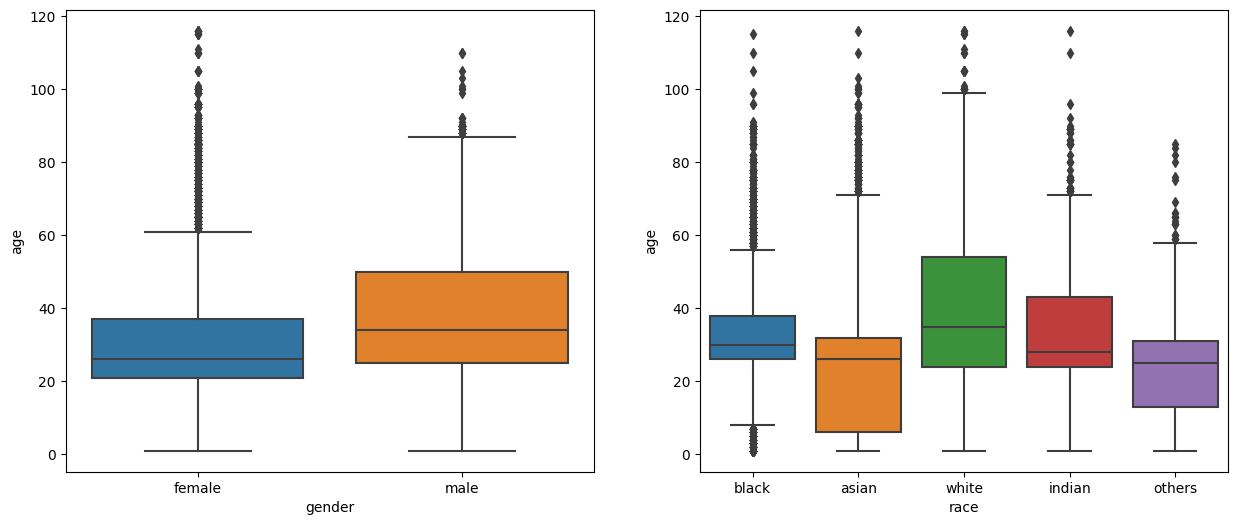

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

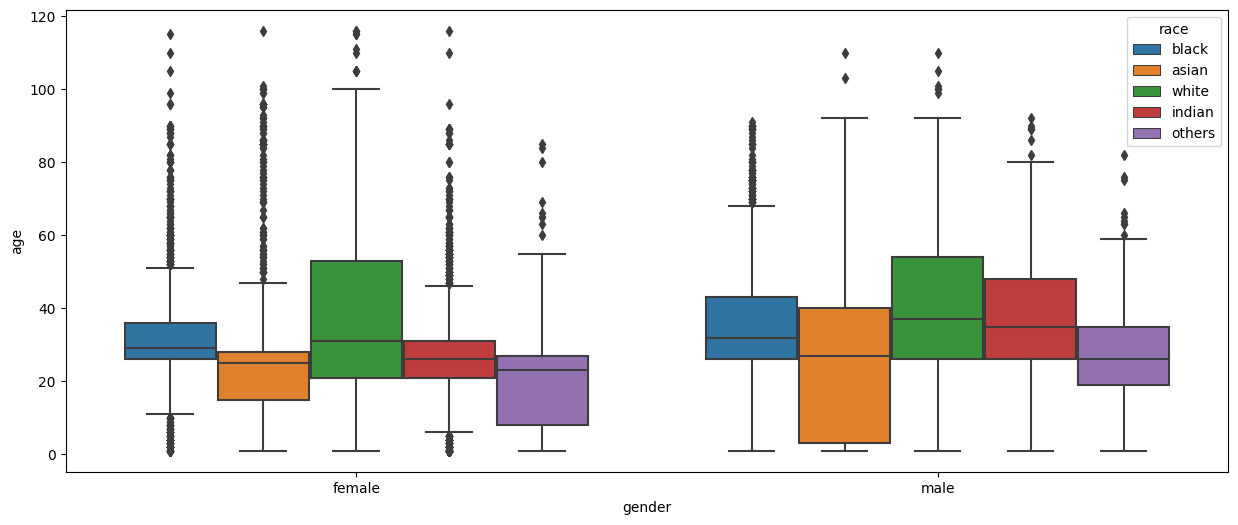

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

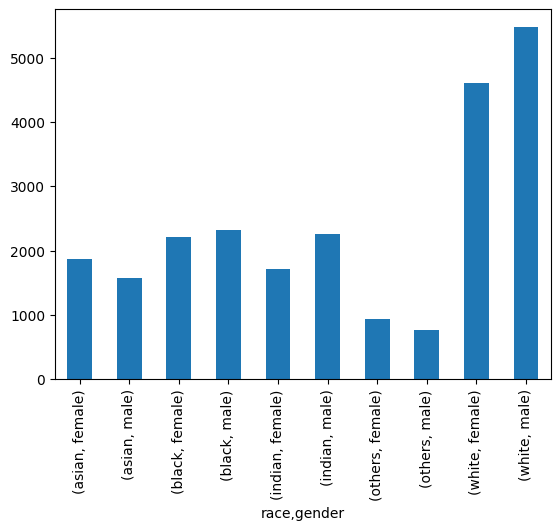

In [ ]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<Axes: >

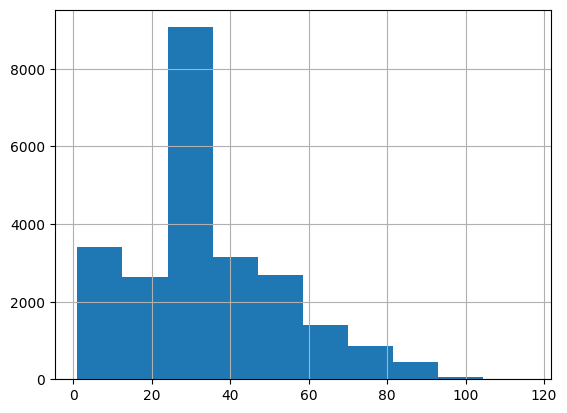

In [ ]:
df['age'].hist()

In [ ]:
df['age'].describe()

count    23735.000000
mean        33.304024
std         19.882642
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [ ]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

### Data pre-processing

In [ ]:

p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

<ipython-input-18-5a78acd6edfb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
<ipython-input-18-5a78acd6edfb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])


(9090, 3897, 5567, 64.0)

In [ ]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

### CNN model

In [ ]:
import tensorflow as tf

In [ ]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

preprocess_input = tf.keras.applications.resnet50.preprocess_input
base_model = tf.keras.applications.resnet50.ResNet50( include_top= False, weights='imagenet', input_shape= (IM_HEIGHT, IM_WIDTH, 3), pooling= None)
base_model.trainable = True
global_max_layer = GlobalMaxPool2D()

# preprocess_input = tf.keras.applications.mobilenet.preprocess_input
# base_model = tf.keras.applications.mobilenet.MobileNet( include_top= False, weights='imagenet', input_shape= (IM_HEIGHT, IM_WIDTH, 3), pooling= None)
# base_model.trainable = True
# global_max_layer = GlobalMaxPool2D()


input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
x = preprocess_input(input_layer)
x = base_model(x, training = True)
x  = global_max_layer(x)

# for age calculation
_ = Dense(units=128, activation='relu')(x)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(x)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(x)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()

94765736/94765736 [==============================] - 3s 0us/step


### Training

In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 16
valid_batch_size = 16
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

<ipython-input-22-59f766453d46>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/10
568/568 [==============================] - ETA: 0s - loss: 4.5873 - age_output_loss: 0.1267 - race_output_loss: 2.0272 - gender_output_loss: 1.2930 - age_output_mae: 0.2860 - race_output_accuracy: 0.3724 - gender_output_accuracy: 0.5294

568/568 [==============================] - 5668s 10s/step - loss: 4.5873 - age_output_loss: 0.1267 - race_output_loss: 2.0272 - gender_output_loss: 1.2930 - age_output_mae: 0.2860 - race_output_accuracy: 0.3724 - gender_output_accuracy: 0.5294 - val_loss: 3.0056 - val_age_output_loss: 0.0675 - val_race_output_loss: 1.4573 - val_gender_output_loss: 0.6846 - val_age_output_mae: 0.1990 - val_race_output_accuracy: 0.4010 - val_gender_output_accuracy: 0.5502
Epoch 2/10
568/568 [==============================] - ETA: 0s - loss: 3.0207 - age_output_loss: 0.0447 - race_output_loss: 1.4915 - gender_output_loss: 0.6940 - age_output_mae: 0.1678 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5322

568/568 [==============================] - 178s 313ms/step - loss: 3.0207 - age_output_loss: 0.0447 - race_output_loss: 1.4915 - gender_output_loss: 0.6940 - age_output_mae: 0.1678 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5322 - val_loss: 2.9905 - val_age_output_loss: 0.0365 - val_race_output_loss: 1.4833 - val_gender_output_loss: 0.6925 - val_age_output_mae: 0.1567 - val_race_output_accuracy: 0.4010 - val_gender_output_accuracy: 0.5201
Epoch 3/10
568/568 [==============================] - ETA: 0s - loss: 2.9625 - age_output_loss: 0.0368 - race_output_loss: 1.4652 - gender_output_loss: 0.6912 - age_output_mae: 0.1574 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5324

568/568 [==============================] - 176s 309ms/step - loss: 2.9625 - age_output_loss: 0.0368 - race_output_loss: 1.4652 - gender_output_loss: 0.6912 - age_output_mae: 0.1574 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5324 - val_loss: 2.9544 - val_age_output_loss: 0.0366 - val_race_output_loss: 1.4589 - val_gender_output_loss: 0.6929 - val_age_output_mae: 0.1576 - val_race_output_accuracy: 0.4007 - val_gender_output_accuracy: 0.5193
Epoch 4/10
568/568 [==============================] - ETA: 0s - loss: 2.9463 - age_output_loss: 0.0368 - race_output_loss: 1.4544 - gender_output_loss: 0.6912 - age_output_mae: 0.1576 - race_output_accuracy: 0.4044 - gender_output_accuracy: 0.5325

568/568 [==============================] - 177s 312ms/step - loss: 2.9463 - age_output_loss: 0.0368 - race_output_loss: 1.4544 - gender_output_loss: 0.6912 - age_output_mae: 0.1576 - race_output_accuracy: 0.4044 - gender_output_accuracy: 0.5325 - val_loss: 2.9485 - val_age_output_loss: 0.0366 - val_race_output_loss: 1.4551 - val_gender_output_loss: 0.6927 - val_age_output_mae: 0.1576 - val_race_output_accuracy: 0.4012 - val_gender_output_accuracy: 0.5203
Epoch 5/10
568/568 [==============================] - ETA: 0s - loss: 2.9437 - age_output_loss: 0.0368 - race_output_loss: 1.4527 - gender_output_loss: 0.6911 - age_output_mae: 0.1576 - race_output_accuracy: 0.4046 - gender_output_accuracy: 0.5325

568/568 [==============================] - 160s 282ms/step - loss: 2.9437 - age_output_loss: 0.0368 - race_output_loss: 1.4527 - gender_output_loss: 0.6911 - age_output_mae: 0.1576 - race_output_accuracy: 0.4046 - gender_output_accuracy: 0.5325 - val_loss: 2.9484 - val_age_output_loss: 0.0366 - val_race_output_loss: 1.4550 - val_gender_output_loss: 0.6928 - val_age_output_mae: 0.1576 - val_race_output_accuracy: 0.4005 - val_gender_output_accuracy: 0.5201
Epoch 6/10
568/568 [==============================] - ETA: 0s - loss: 2.9434 - age_output_loss: 0.0368 - race_output_loss: 1.4525 - gender_output_loss: 0.6912 - age_output_mae: 0.1576 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5324

568/568 [==============================] - 159s 280ms/step - loss: 2.9434 - age_output_loss: 0.0368 - race_output_loss: 1.4525 - gender_output_loss: 0.6912 - age_output_mae: 0.1576 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5324 - val_loss: 2.9474 - val_age_output_loss: 0.0365 - val_race_output_loss: 1.4545 - val_gender_output_loss: 0.6927 - val_age_output_mae: 0.1576 - val_race_output_accuracy: 0.4007 - val_gender_output_accuracy: 0.5195
Epoch 7/10
568/568 [==============================] - ETA: 0s - loss: 2.9432 - age_output_loss: 0.0367 - race_output_loss: 1.4523 - gender_output_loss: 0.6912 - age_output_mae: 0.1577 - race_output_accuracy: 0.4046 - gender_output_accuracy: 0.5324

568/568 [==============================] - 160s 282ms/step - loss: 2.9432 - age_output_loss: 0.0367 - race_output_loss: 1.4523 - gender_output_loss: 0.6912 - age_output_mae: 0.1577 - race_output_accuracy: 0.4046 - gender_output_accuracy: 0.5324 - val_loss: 2.9469 - val_age_output_loss: 0.0365 - val_race_output_loss: 1.4541 - val_gender_output_loss: 0.6927 - val_age_output_mae: 0.1575 - val_race_output_accuracy: 0.4012 - val_gender_output_accuracy: 0.5195
Epoch 8/10
568/568 [==============================] - ETA: 0s - loss: 2.9434 - age_output_loss: 0.0368 - race_output_loss: 1.4525 - gender_output_loss: 0.6911 - age_output_mae: 0.1577 - race_output_accuracy: 0.4044 - gender_output_accuracy: 0.5326

568/568 [==============================] - 158s 278ms/step - loss: 2.9434 - age_output_loss: 0.0368 - race_output_loss: 1.4525 - gender_output_loss: 0.6911 - age_output_mae: 0.1577 - race_output_accuracy: 0.4044 - gender_output_accuracy: 0.5326 - val_loss: 2.9473 - val_age_output_loss: 0.0366 - val_race_output_loss: 1.4543 - val_gender_output_loss: 0.6927 - val_age_output_mae: 0.1576 - val_race_output_accuracy: 0.4005 - val_gender_output_accuracy: 0.5198
Epoch 9/10
568/568 [==============================] - ETA: 0s - loss: 2.9433 - age_output_loss: 0.0368 - race_output_loss: 1.4524 - gender_output_loss: 0.6911 - age_output_mae: 0.1577 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5325

568/568 [==============================] - 177s 311ms/step - loss: 2.9433 - age_output_loss: 0.0368 - race_output_loss: 1.4524 - gender_output_loss: 0.6911 - age_output_mae: 0.1577 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5325 - val_loss: 2.9488 - val_age_output_loss: 0.0365 - val_race_output_loss: 1.4553 - val_gender_output_loss: 0.6928 - val_age_output_mae: 0.1575 - val_race_output_accuracy: 0.3999 - val_gender_output_accuracy: 0.5195
Epoch 10/10
568/568 [==============================] - ETA: 0s - loss: 2.9433 - age_output_loss: 0.0368 - race_output_loss: 1.4525 - gender_output_loss: 0.6911 - age_output_mae: 0.1576 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5325

568/568 [==============================] - 159s 280ms/step - loss: 2.9433 - age_output_loss: 0.0368 - race_output_loss: 1.4525 - gender_output_loss: 0.6911 - age_output_mae: 0.1576 - race_output_accuracy: 0.4045 - gender_output_accuracy: 0.5325 - val_loss: 2.9487 - val_age_output_loss: 0.0365 - val_race_output_loss: 1.4553 - val_gender_output_loss: 0.6929 - val_age_output_mae: 0.1574 - val_race_output_accuracy: 0.4002 - val_gender_output_accuracy: 0.5188


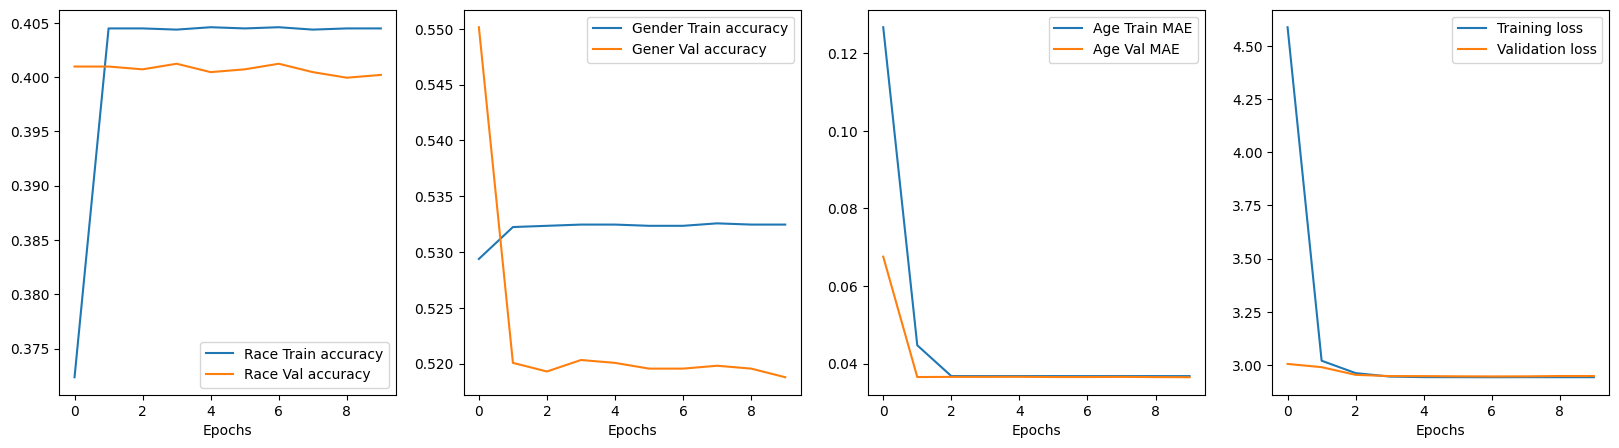

In [ ]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

### Evaluation

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

<ipython-input-24-d6456e542e93>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))


{'loss': 2.9394354820251465,
 'age_output_loss': 0.037500765174627304,
 'race_output_loss': 1.4486055374145508,
 'gender_output_loss': 0.6915259957313538,
 'age_output_mae': 0.15946520864963531,
 'race_output_accuracy': 0.40933865308761597,
 'gender_output_accuracy': 0.5288881063461304}

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [ ]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [ ]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.45      1.00      0.62        58
           1       0.00      0.00      0.00        34
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00         8

    accuracy                           0.45       128
   macro avg       0.09      0.20      0.12       128
weighted avg       0.21      0.45      0.28       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        71
           1       0.00      0.00      0.00        57

    accuracy                           0.55       128
   macro avg       0.28      0.50      0.36       128
weighted avg       0.31      0.55      0.40       128



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

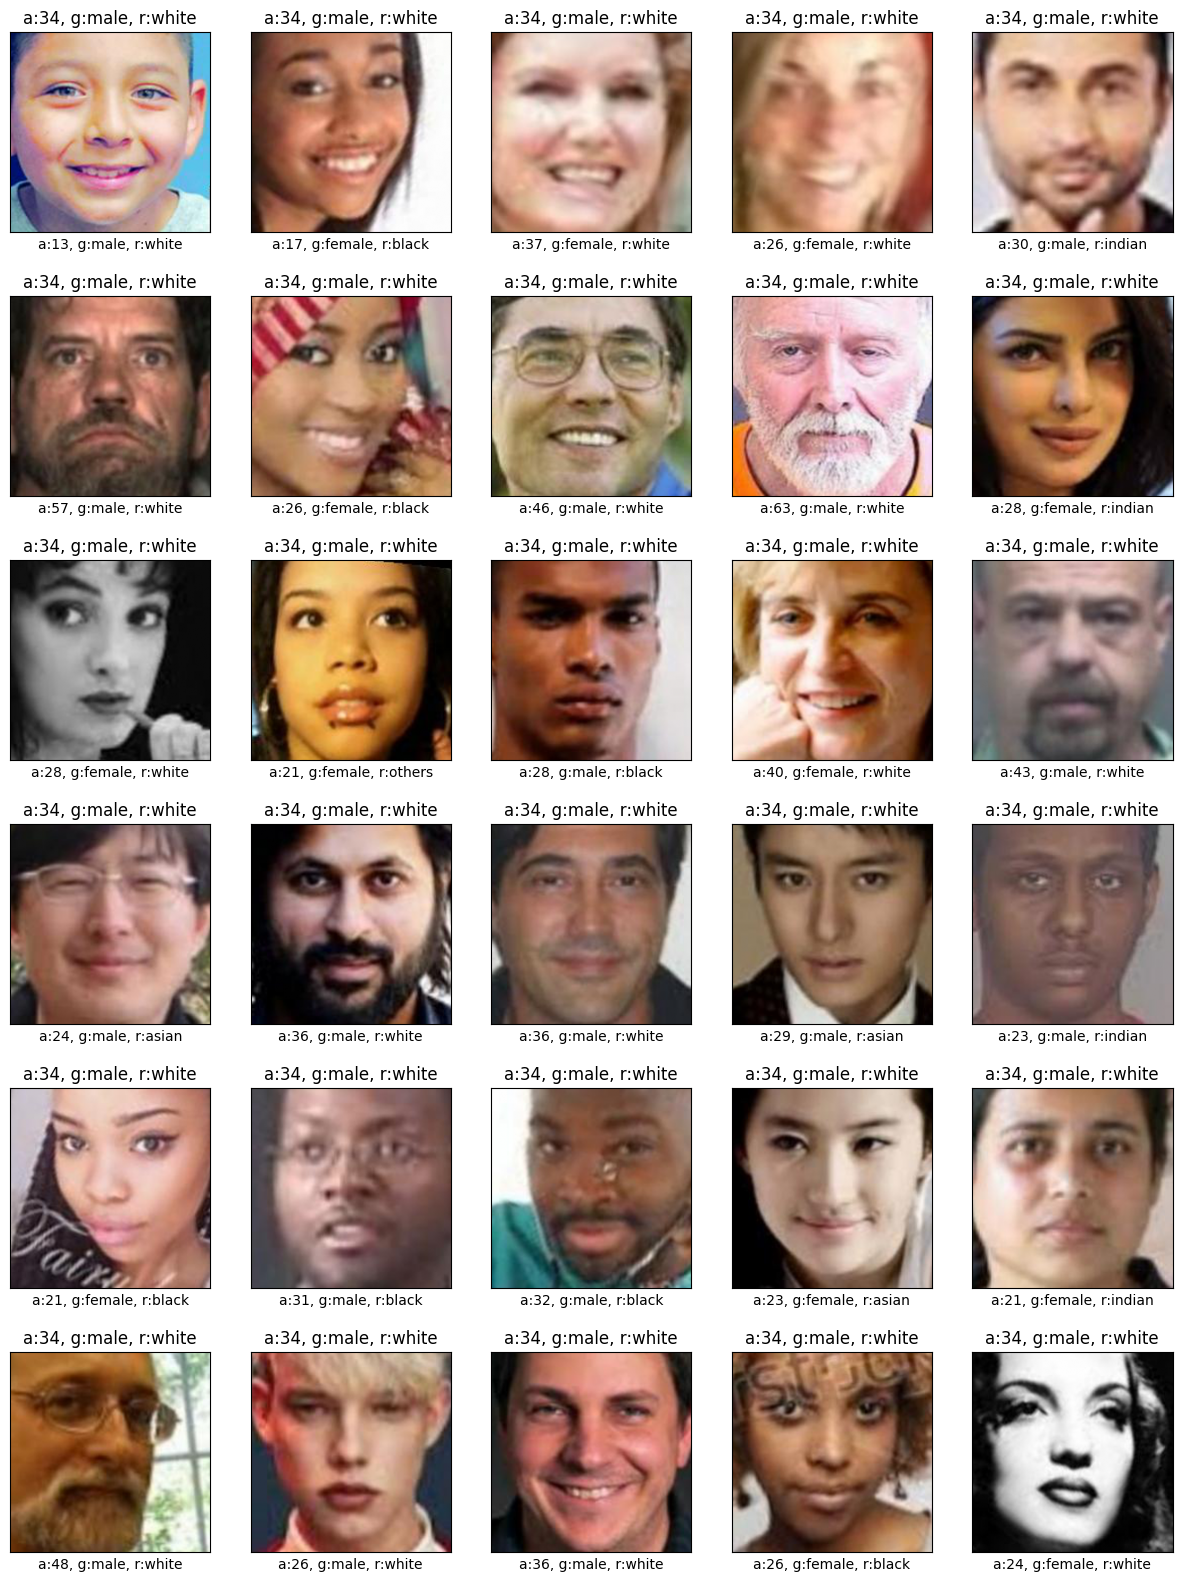

In [ ]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])